<a href="https://colab.research.google.com/github/Quercusoak/CNN_CIFAR10/blob/main/cnn_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cifar-10 CNN



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
import numpy as np
import random
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from math import floor

## Data

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Normalize for cifar-10
mean = (0.5, 0.5, 0.5)
std = (0.2, 0.2, 0.2)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean,std)])

# Load the CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

cuda:0


100%|██████████| 170M/170M [00:36<00:00, 4.63MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Funcs

#### Accuracy

In [ ]:
def accuracy(model, data_loader):
  correct = 0
  total = 0
  with torch.no_grad():
      for data, target in data_loader:
          data, target = data.to(device), target.to(device)
          outputs = model(data)
          _, predicted = torch.max(outputs.data, 1)
          total += target.size(0)
          correct += (predicted == target).sum().item()
  return 100 * correct / total

#### Plot

In [ ]:
def plot_loss(train_loss, val_loss):
  bias = train_loss[-1]
  variance = val_loss[-1]-train_loss[-1]
  print(f'bias: {bias:.4f}, variance: {variance:.4f}')

  plt.plot(train_loss, label='train loss', color='tab:red')
  plt.plot(val_loss, label='validation loss', color='tab:blue')
  plt.xlabel('epochs')
  plt.legend()

#### conv_output_shape

In [ ]:
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    #by Duane Nielsen
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

#### Training and evaluate

In [ ]:
def train_model(model, criterion, optimizer):
    model.train()
    train_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    return train_loss/i+1


def evaluate_model(model, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
      for i, data in enumerate(test_loader):
            test_data, test_target = data[0].to(device), data[1].to(device)
            outputs = model(test_data)
            loss = criterion(outputs, test_target)
            val_loss += loss.item()

    return val_loss/i+1


def train_epochs(model, criterion, optimizer, num_epochs):
  train_loss = []
  val_loss = []

  for epoch in range(num_epochs):
    train_loss_epoch = train_model(model, criterion, optimizer)
    train_loss.append(train_loss_epoch)

    test_loss_epoch = evaluate_model(model, criterion)
    val_loss.append(test_loss_epoch)

    print(f'epoch #{epoch+1}/{num_epochs}: train loss {train_loss_epoch:.4f}, val loss {test_loss_epoch:.4f}')

  return train_loss, val_loss

## Experiments

### Models

In [ ]:
#kernel 3 first layer, others 5; padding=2; two outer linear layers
class CNN1(nn.Module):
    def __init__(self, layers):
      super(CNN1, self).__init__()
      self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
      self.layers = nn.ModuleList()

      self.layers.append(nn.Conv2d(3, layers[0],kernel_size=3, stride=1, padding=2))  #RGB means 3 in_channels
      out=conv_output_shape((32,32), kernel_size=3, stride=1, pad=2)  # calc output size for fully connected layer
      out = conv_output_shape(out, 2,2)  # maxpool

      for input, output in zip(layers, layers[1:]):
        self.layers.append(nn.Conv2d(input, output, kernel_size=5, padding=2))
        out = conv_output_shape(out, kernel_size=5,pad =2)  # hidden layer
        out = conv_output_shape(out, 2,2)  # maxpool

      output_size = out[0]
      self.out1 = nn.Linear(layers[-1]*output_size*output_size, 120)
      self.out2 = nn.Linear(120, 10)

    def forward(self, x):
      for layer in self.layers:
        x = self.pool(F.relu(layer(x)))
      x = torch.flatten(x, 1) # flatten all dimensions except batch
      x = F.relu(self.out1(x))
      x = self.out2(x)
      return x

In [ ]:
#kernel 3 first conv layer, others 5; padding=2 after first conv layer; two outer linear layers
class CNN_no_Pad(nn.Module):
    def __init__(self, layers):
      super(CNN_no_Pad, self).__init__()
      self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
      self.layers = nn.ModuleList()

      self.layers.append(nn.Conv2d(3, layers[0],kernel_size=3, stride=1, padding=1))  #RGB means 3 in_channels
      out=conv_output_shape((32,32), kernel_size=3, stride=1, pad=1)  # calc output size for fully connected layer
      out = conv_output_shape(out, 2,2)  # maxpool

      for input, output in zip(layers, layers[1:]):
        self.layers.append(nn.Conv2d(input, output, kernel_size=5, padding=2))
        out = conv_output_shape(out, kernel_size=5,pad =2)  # hidden layer
        out = conv_output_shape(out, 2,2)  # maxpool

      output_size = out[0]
      self.out1 = nn.Linear(layers[-1]*output_size*output_size, 120)
      self.out2 = nn.Linear(120, 10)

    def forward(self, x):
      for layer in self.layers:
        x = self.pool(F.relu(layer(x)))
      x = torch.flatten(x, 1) # flatten all dimensions except batch
      x = F.relu(self.out1(x))
      x = self.out2(x)
      return x

In [ ]:
# kernel size and padding the same for all conv layer; 3 outer linear layers with more neurons
class CNN4(nn.Module):
    def __init__(self, layers, f, pad):
      super(CNN4, self).__init__()
      self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
      self.layers = nn.ModuleList()

      out= (32,32) # calc output size for fully connected layer

      for input, output in zip(layers, layers[1:]):
        self.layers.append(nn.Conv2d(input, output, kernel_size=f, padding=pad))
        out = conv_output_shape(out, kernel_size=f,pad =pad)  # conv layer
        out = conv_output_shape(out, 2,2)  # maxpool

      output_size = out[0]
      self.out1 = nn.Linear(layers[-1]*output_size*output_size, 512)
      self.out2 = nn.Linear(512, 120)
      self.out3 = nn.Linear(120, 10)


    def forward(self, x):
      for layer in self.layers:
        x = self.pool(F.relu(layer(x)))
      x = torch.flatten(x, 1) # flatten all dimensions except batch
      x = F.relu(self.out1(x))
      x = F.relu(self.out2(x))
      x = self.out3(x)
      return x

### batch size 64

test optimizers and learning rate for cross entropy loss and given layers

In [ ]:
batch_size = 64
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

layers=[32,64,128,256]
criterion = nn.CrossEntropyLoss()
num_epochs = 15

In [ ]:
m = CNN1([32,64,128,256])
print(m)

CNN1(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (out1): Linear(in_features=1024, out_features=120, bias=True)
  (out2): Linear(in_features=120, out_features=10, bias=True)
)


#### Adam optim

Test Adam optimizer.

epoch #1/15: train loss 3.4184, val loss 3.3180
epoch #2/15: train loss 3.3067, val loss 3.3183
epoch #3/15: train loss 3.3067, val loss 3.3183
epoch #4/15: train loss 3.3065, val loss 3.3188
epoch #5/15: train loss 3.3064, val loss 3.3176
epoch #6/15: train loss 3.3066, val loss 3.3181
epoch #7/15: train loss 3.3063, val loss 3.3177
epoch #8/15: train loss 3.3067, val loss 3.3180
epoch #9/15: train loss 3.3068, val loss 3.3178
epoch #10/15: train loss 3.3064, val loss 3.3181
epoch #11/15: train loss 3.3067, val loss 3.3179
epoch #12/15: train loss 3.3066, val loss 3.3178
epoch #13/15: train loss 3.3064, val loss 3.3183
epoch #14/15: train loss 3.3066, val loss 3.3184
epoch #15/15: train loss 3.3064, val loss 3.3187
Accuracy: 10.0%
bias: 3.3064, variance: 0.0123


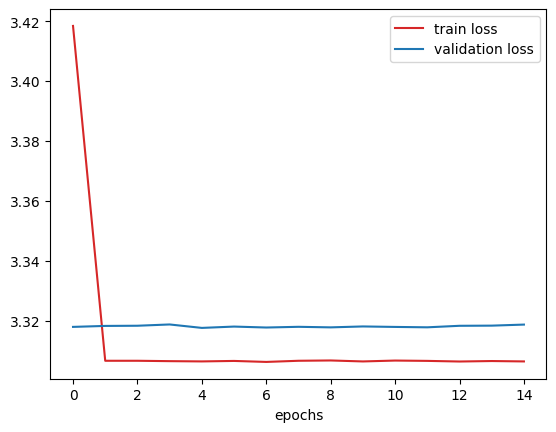

In [ ]:
model = CNN1(layers)
optimizer = optim.Adam(model.parameters(), lr=0.01)
model.to(device)

train_loss, val_loss = train_epochs(model, criterion, optimizer, num_epochs)
model.eval();
print(f'Accuracy: {accuracy(model,test_loader)}%')
plot_loss(train_loss, val_loss)

Result: Very high bias, model is not learning - need to lower learning rate.

epoch #1/15: train loss 2.5415, val loss 2.2145
epoch #2/15: train loss 2.1091, val loss 2.1054
epoch #3/15: train loss 1.9370, val loss 1.9512
epoch #4/15: train loss 1.8122, val loss 1.8908
epoch #5/15: train loss 1.7259, val loss 1.9214
epoch #6/15: train loss 1.6410, val loss 1.8989
epoch #7/15: train loss 1.5783, val loss 1.9241
epoch #8/15: train loss 1.5125, val loss 1.9833
epoch #9/15: train loss 1.4597, val loss 2.0034
epoch #10/15: train loss 1.4151, val loss 2.0913
epoch #11/15: train loss 1.3711, val loss 2.1760
epoch #12/15: train loss 1.3396, val loss 2.2580
epoch #13/15: train loss 1.3144, val loss 2.2771
epoch #14/15: train loss 1.2945, val loss 2.3712
epoch #15/15: train loss 1.2771, val loss 2.4300
Accuracy: 69.53%
bias: 1.2771, variance: 1.1529


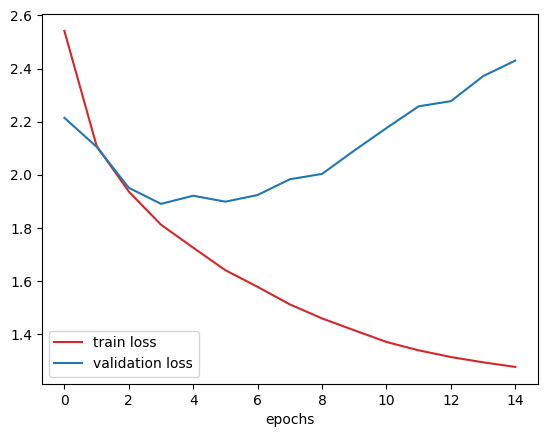

In [ ]:
model = CNN1(layers)
optimizer = optim.Adam(model.parameters(), lr=0.002)
model.to(device)

train_loss, val_loss = train_epochs(model, criterion, optimizer, num_epochs)
model.eval();
print(f'Accuracy: {accuracy(model,test_loader)}%')
plot_loss(train_loss, val_loss)

Result: train loss low but validation loss grows - overfitting.

Smaller learning rate

epoch #1/15: train loss 2.4409, val loss 2.1120
epoch #2/15: train loss 1.9550, val loss 1.8748
epoch #3/15: train loss 1.7320, val loss 1.7721
epoch #4/15: train loss 1.5805, val loss 1.7177
epoch #5/15: train loss 1.4468, val loss 1.7421
epoch #6/15: train loss 1.3265, val loss 1.7738
epoch #7/15: train loss 1.2174, val loss 1.8830
epoch #8/15: train loss 1.1416, val loss 1.9692
epoch #9/15: train loss 1.1140, val loss 2.0868
epoch #10/15: train loss 1.0904, val loss 2.1613
epoch #11/15: train loss 1.0833, val loss 2.2450
epoch #12/15: train loss 1.0740, val loss 2.3391
epoch #13/15: train loss 1.0627, val loss 2.4337
epoch #14/15: train loss 1.0671, val loss 2.3852
epoch #15/15: train loss 1.0610, val loss 2.4295
Accuracy: 75.74%
bias: 1.0610, variance: 1.3685


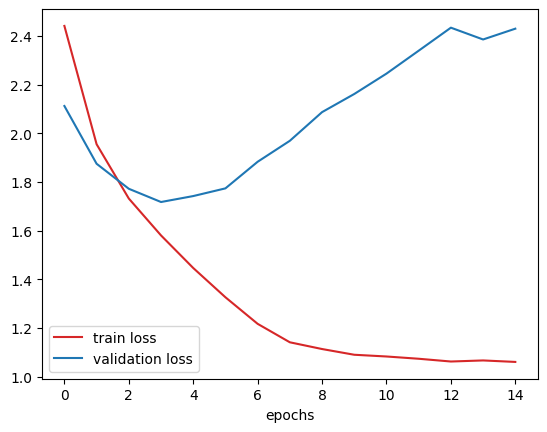

In [ ]:
model = CNN1(layers)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
model.to(device)

train_loss, val_loss = train_epochs(model, criterion, optimizer, num_epochs)
model.eval();
print(f'Accuracy: {accuracy(model,test_loader)}%')
plot_loss(train_loss, val_loss)

Result: better bias means the model learns more, but the model is still overfitting.

#### SGD optim

Test SGD optimizer with learning rate as last experiment, to see if there are better parameters for better accuracy.

epoch #1/15: train loss 3.0022, val loss 2.7230
epoch #2/15: train loss 2.5091, val loss 2.4004
epoch #3/15: train loss 2.2841, val loss 2.2066
epoch #4/15: train loss 2.1091, val loss 2.0769
epoch #5/15: train loss 1.9653, val loss 1.9932
epoch #6/15: train loss 1.8596, val loss 1.9101
epoch #7/15: train loss 1.7579, val loss 1.8667
epoch #8/15: train loss 1.6684, val loss 1.8084
epoch #9/15: train loss 1.5797, val loss 1.7752
epoch #10/15: train loss 1.4855, val loss 1.7844
epoch #11/15: train loss 1.4047, val loss 1.7794
epoch #12/15: train loss 1.3218, val loss 1.8530
epoch #13/15: train loss 1.2502, val loss 1.9332
epoch #14/15: train loss 1.1845, val loss 1.9342
epoch #15/15: train loss 1.1256, val loss 2.0855
Accuracy: 74.35%
bias: 1.1256, variance: 0.9599


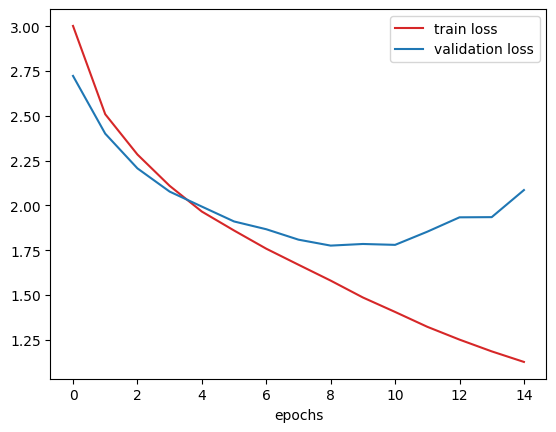

In [ ]:
model = CNN1(layers)
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)
model.to(device)

train_loss, val_loss = train_epochs(model, criterion, optimizer, num_epochs)
model.eval();
print(f'Accuracy: {accuracy(model,test_loader)}%')
plot_loss(train_loss, val_loss)

Result: lower variance, less overfitting.

Let's try larger momentum.

epoch #1/15: train loss 2.6407, val loss 2.3188
epoch #2/15: train loss 2.0701, val loss 1.9478
epoch #3/15: train loss 1.8128, val loss 1.8566
epoch #4/15: train loss 1.6452, val loss 1.8296
epoch #5/15: train loss 1.5100, val loss 1.8154
epoch #6/15: train loss 1.3959, val loss 1.8001
epoch #7/15: train loss 1.3087, val loss 1.8366
epoch #8/15: train loss 1.2421, val loss 1.9476
epoch #9/15: train loss 1.1990, val loss 1.9838
epoch #10/15: train loss 1.1678, val loss 2.0600
epoch #11/15: train loss 1.1398, val loss 2.1924
epoch #12/15: train loss 1.1275, val loss 2.1480
epoch #13/15: train loss 1.1055, val loss 2.3001
epoch #14/15: train loss 1.1039, val loss 2.2163
epoch #15/15: train loss 1.0838, val loss 2.5117
Accuracy: 75.05%
bias: 1.0838, variance: 1.4279


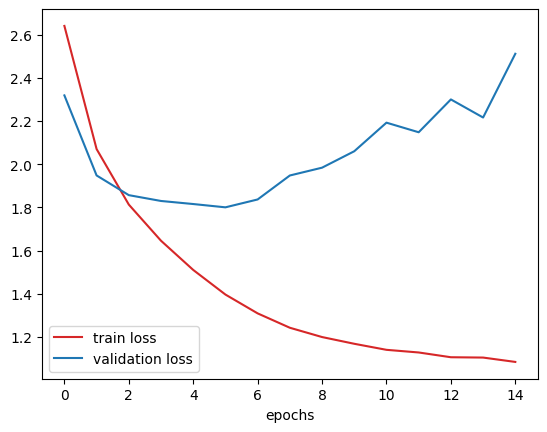

In [ ]:
model = CNN1(layers)
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.99)
model.to(device)

train_loss, val_loss = train_epochs(model, criterion, optimizer, num_epochs)
model.eval();
print(f'Accuracy: {accuracy(model,test_loader)}%')
plot_loss(train_loss, val_loss)

Result: worse overfitting, higher variance.

Try diffrent architecture, lower momentum

epoch #1/10: train loss 3.3057, val loss 3.3159
epoch #2/10: train loss 3.3025, val loss 3.3121
epoch #3/10: train loss 3.2960, val loss 3.3001
epoch #4/10: train loss 3.2468, val loss 3.1532
epoch #5/10: train loss 3.0392, val loss 2.9649
epoch #6/10: train loss 2.8976, val loss 2.8313
epoch #7/10: train loss 2.7685, val loss 2.7291
epoch #8/10: train loss 2.6810, val loss 2.6555
epoch #9/10: train loss 2.6207, val loss 2.5781
epoch #10/10: train loss 2.5595, val loss 2.5164
Accuracy: 44.09%
bias: 2.5595, variance: -0.0431


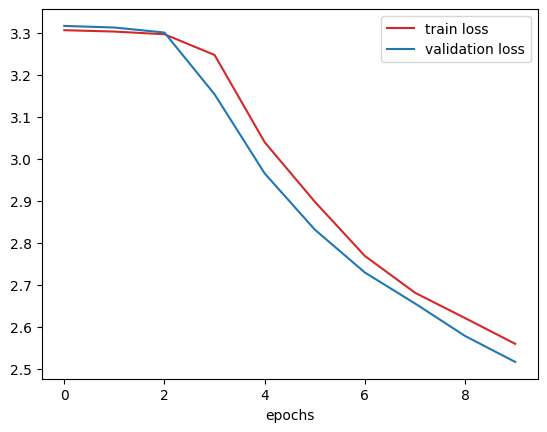

In [ ]:
num_epochs =10
model = CNN1(layers=[64,128,256,512,512])
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.85)
model.to(device)

train_loss, val_loss = train_epochs(model, criterion, optimizer, num_epochs)
model.eval();
print(f'Accuracy: {accuracy(model,test_loader)}%')
plot_loss(train_loss, val_loss)

Result: model doesn't learn enough from the data. Variance negative - underfitting.

### test other architectures

Decided to use adam optim due to better results.

Try adam with other model architecture.

test padding = 1 for inner layers

epoch #1/10: train loss 2.6924, val loss 2.4561
epoch #2/10: train loss 2.3581, val loss 2.2746
epoch #3/10: train loss 2.2049, val loss 2.1446
epoch #4/10: train loss 2.0848, val loss 2.0798
epoch #5/10: train loss 1.9888, val loss 2.0155
epoch #6/10: train loss 1.9055, val loss 1.9569
epoch #7/10: train loss 1.8342, val loss 1.9227
epoch #8/10: train loss 1.7703, val loss 1.8886
epoch #9/10: train loss 1.7086, val loss 1.8313
epoch #10/10: train loss 1.6440, val loss 1.8565
Accuracy: 70.45%
bias: 1.6440, variance: 0.2125


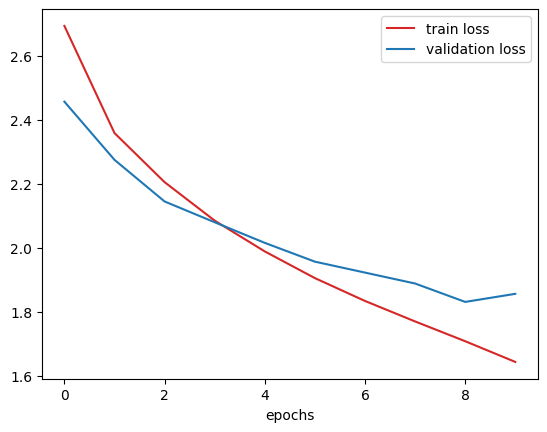

In [ ]:
model = CNN_no_Pad(layers)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.to(device)

train_loss, val_loss = train_epochs(model, criterion, optimizer, num_epochs)
model.eval();
print(f'Accuracy: {accuracy(model,test_loader)}%')
plot_loss(train_loss, val_loss)

test kernel size 3 with another linear layer with more neurons

epoch #1/15: train loss 2.7374, val loss 2.5247
epoch #2/15: train loss 2.4243, val loss 2.3596
epoch #3/15: train loss 2.2894, val loss 2.2310
epoch #4/15: train loss 2.1810, val loss 2.1544
epoch #5/15: train loss 2.0889, val loss 2.0562
epoch #6/15: train loss 2.0133, val loss 2.0199
epoch #7/15: train loss 1.9426, val loss 2.0158
epoch #8/15: train loss 1.8819, val loss 1.9434
epoch #9/15: train loss 1.8269, val loss 1.8810
epoch #10/15: train loss 1.7750, val loss 1.8535
epoch #11/15: train loss 1.7219, val loss 1.8471
epoch #12/15: train loss 1.6762, val loss 1.8069
epoch #13/15: train loss 1.6353, val loss 1.8140
epoch #14/15: train loss 1.5896, val loss 1.8161
epoch #15/15: train loss 1.5472, val loss 1.7716
Accuracy: 73.75%
bias: 1.5472, variance: 0.2245


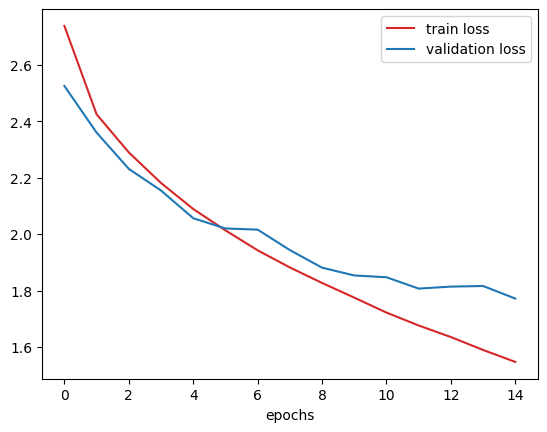

In [ ]:
num_epochs = 15
layers=[3,32,64,128,256]
model = CNN4(layers,3,2)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.to(device)

train_loss, val_loss = train_epochs(model, criterion, optimizer, num_epochs)
model.eval();
print(f'Accuracy: {accuracy(model,test_loader)}%')
plot_loss(train_loss, val_loss)

In [ ]:
m = CNN4([3,32,64,128,256],3,2)
print(m)

CNN4(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (out1): Linear(in_features=2304, out_features=512, bias=True)
  (out2): Linear(in_features=512, out_features=120, bias=True)
  (out3): Linear(in_features=120, out_features=10, bias=True)
)


kernel size 5

epoch #1/15: train loss 3.3065, val loss 3.3183
epoch #2/15: train loss 3.3065, val loss 3.3183
epoch #3/15: train loss 3.3066, val loss 3.3183
epoch #4/15: train loss 3.3065, val loss 3.3183
epoch #5/15: train loss 3.3065, val loss 3.3183
epoch #6/15: train loss 3.3065, val loss 3.3183
epoch #7/15: train loss 3.3065, val loss 3.3183
epoch #8/15: train loss 3.3065, val loss 3.3183
epoch #9/15: train loss 3.3065, val loss 3.3183
epoch #10/15: train loss 3.3065, val loss 3.3183
epoch #11/15: train loss 3.3066, val loss 3.3183
epoch #12/15: train loss 3.3066, val loss 3.3183
epoch #13/15: train loss 3.3065, val loss 3.3183
epoch #14/15: train loss 3.3066, val loss 3.3183
epoch #15/15: train loss 3.3065, val loss 3.3183
Accuracy: 7.93%
bias: 3.3065, variance: 0.0118


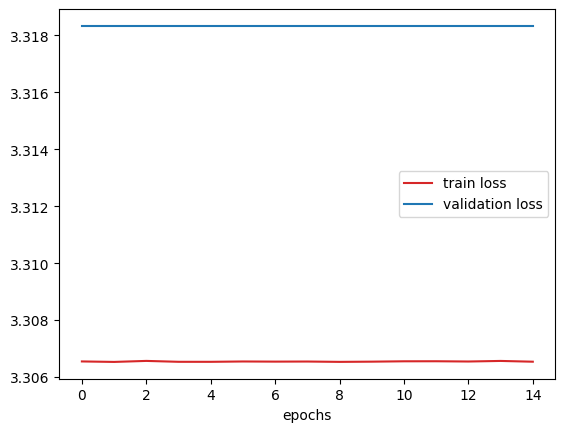

In [ ]:
model = CNN4(layers,5,2)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.to(device)

train_loss, val_loss = train_epochs(model, criterion, optimizer, num_epochs)
model.eval();
print(f'Accuracy: {accuracy(model,test_loader)}%')
plot_loss(train_loss, val_loss)

kernel size 3 and larger learning rate

epoch #1/15: train loss 2.4984, val loss 2.2791
epoch #2/15: train loss 2.0640, val loss 1.9587
epoch #3/15: train loss 1.8342, val loss 1.9085
epoch #4/15: train loss 1.6822, val loss 1.7638
epoch #5/15: train loss 1.5596, val loss 1.6999
epoch #6/15: train loss 1.4496, val loss 1.7194
epoch #7/15: train loss 1.3536, val loss 1.7621
epoch #8/15: train loss 1.2697, val loss 1.7690
epoch #9/15: train loss 1.1953, val loss 1.8931
epoch #10/15: train loss 1.1478, val loss 2.0044
epoch #11/15: train loss 1.1185, val loss 2.1408
epoch #12/15: train loss 1.1022, val loss 2.1756
epoch #13/15: train loss 1.0879, val loss 2.2299
epoch #14/15: train loss 1.0804, val loss 2.1425
epoch #15/15: train loss 1.0744, val loss 2.2673
Accuracy: 76.43%
bias: 1.0744, variance: 1.1929


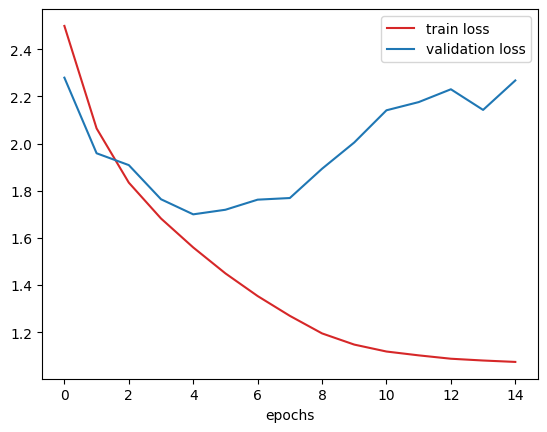

In [ ]:
layers=[3,32,64,128,256]
model = CNN4(layers,3,2)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
model.to(device)

train_loss, val_loss = train_epochs(model, criterion, optimizer, num_epochs)
model.eval();
print(f'Accuracy: {accuracy(model,test_loader)}%')
plot_loss(train_loss, val_loss)

test more layers, deeper

epoch #1/15: train loss 2.3712, val loss 2.1199
epoch #2/15: train loss 1.8939, val loss 1.8581
epoch #3/15: train loss 1.6872, val loss 1.7495
epoch #4/15: train loss 1.5302, val loss 1.7159
epoch #5/15: train loss 1.4044, val loss 1.6887
epoch #6/15: train loss 1.2874, val loss 1.7405
epoch #7/15: train loss 1.1999, val loss 1.8482
epoch #8/15: train loss 1.1382, val loss 1.9954
epoch #9/15: train loss 1.1026, val loss 2.0682
epoch #10/15: train loss 1.0945, val loss 2.0610
epoch #11/15: train loss 1.0745, val loss 2.2280
epoch #12/15: train loss 1.0680, val loss 2.2429
epoch #13/15: train loss 1.0617, val loss 2.2369
epoch #14/15: train loss 1.0624, val loss 2.3315
epoch #15/15: train loss 1.0496, val loss 2.3788
Accuracy: 76.65%
bias: 1.0496, variance: 1.3291


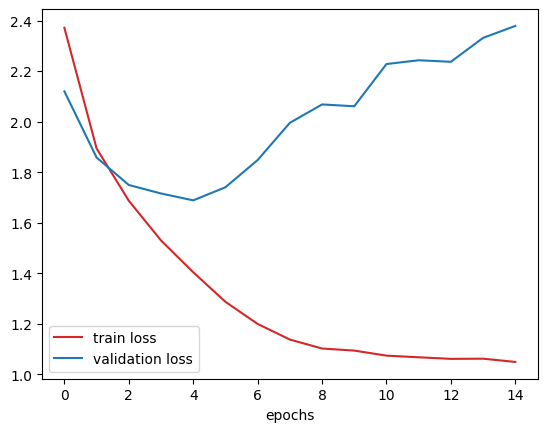

In [ ]:
layers=[3,96,192,192]
model = CNN4(layers,3,2)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
model.to(device)

train_loss, val_loss = train_epochs(model, criterion, optimizer, num_epochs)
model.eval();
print(f'Accuracy: {accuracy(model,test_loader)}%')
plot_loss(train_loss, val_loss)

epoch #1/15: train loss 2.5593, val loss 2.2919
epoch #2/15: train loss 2.0165, val loss 1.8929
epoch #3/15: train loss 1.7468, val loss 1.7342
epoch #4/15: train loss 1.5596, val loss 1.7419
epoch #5/15: train loss 1.4152, val loss 1.7482
epoch #6/15: train loss 1.2930, val loss 1.7611
epoch #7/15: train loss 1.1965, val loss 1.8203
epoch #8/15: train loss 1.1435, val loss 2.0412
epoch #9/15: train loss 1.1154, val loss 1.9996
epoch #10/15: train loss 1.0980, val loss 2.0661
epoch #11/15: train loss 1.0758, val loss 2.0518
epoch #12/15: train loss 1.0732, val loss 2.1588
epoch #13/15: train loss 1.0699, val loss 2.1673
epoch #14/15: train loss 1.0613, val loss 2.1070
epoch #15/15: train loss 1.0588, val loss 2.1270
Accuracy: 77.58%
bias: 1.0588, variance: 1.0682


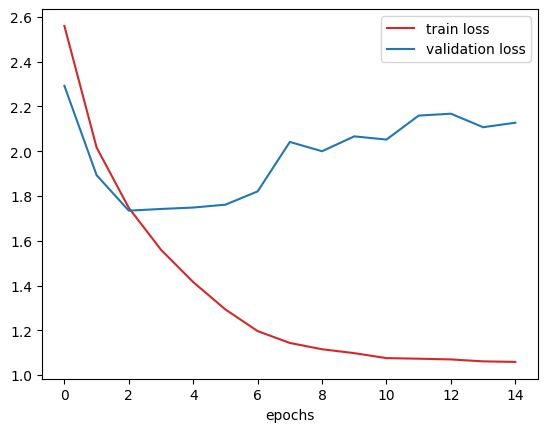

In [ ]:
layers=[3,64,128,256,512,512]
model = CNN4(layers,3,2)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
model.to(device)

train_loss, val_loss = train_epochs(model, criterion, optimizer, num_epochs)
model.eval();
print(f'Accuracy: {accuracy(model,test_loader)}%')
plot_loss(train_loss, val_loss)

### batch size 128

epoch #1/15: train loss 2.6199, val loss 2.2395
epoch #2/15: train loss 2.1125, val loss 1.9933
epoch #3/15: train loss 1.8367, val loss 1.8340
epoch #4/15: train loss 1.6477, val loss 1.7434
epoch #5/15: train loss 1.4977, val loss 1.7144
epoch #6/15: train loss 1.3569, val loss 1.7613
epoch #7/15: train loss 1.2443, val loss 1.8103
epoch #8/15: train loss 1.1618, val loss 1.8412
epoch #9/15: train loss 1.1152, val loss 1.9659
epoch #10/15: train loss 1.0874, val loss 2.0917
epoch #11/15: train loss 1.0762, val loss 2.1261
epoch #12/15: train loss 1.0668, val loss 2.1725
epoch #13/15: train loss 1.0588, val loss 2.2160
epoch #14/15: train loss 1.0567, val loss 2.1408
epoch #15/15: train loss 1.0504, val loss 2.1939
Accuracy: 78.11%
bias: 1.0504, variance: 1.1434


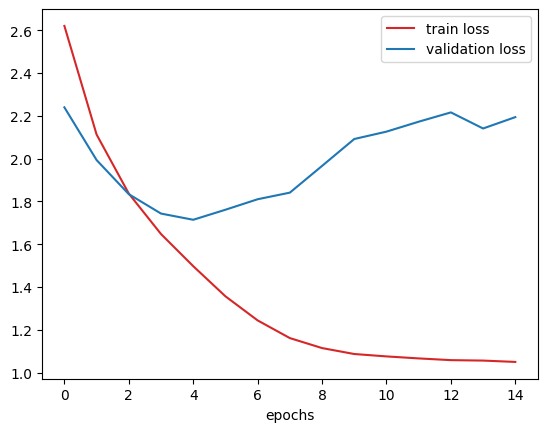

In [ ]:
train_loader = DataLoader(trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(testset, batch_size=128, shuffle=False)

layers=[3,64,128,256,512,512]
model = CNN4(layers,3,2)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
model.to(device)

train_loss, val_loss = train_epochs(model, criterion, optimizer, num_epochs)
model.eval();
print(f'Accuracy: {accuracy(model,test_loader)}%')
plot_loss(train_loss, val_loss)

### batch size 32

epoch #1/15: train loss 2.4693, val loss 2.1051
epoch #2/15: train loss 1.9313, val loss 1.9727
epoch #3/15: train loss 1.6832, val loss 1.7709
epoch #4/15: train loss 1.5176, val loss 1.7362
epoch #5/15: train loss 1.3795, val loss 1.7583
epoch #6/15: train loss 1.2695, val loss 1.8310
epoch #7/15: train loss 1.1950, val loss 1.8964
epoch #8/15: train loss 1.1514, val loss 1.9747
epoch #9/15: train loss 1.1256, val loss 1.9734
epoch #10/15: train loss 1.1060, val loss 2.0998
epoch #11/15: train loss 1.0972, val loss 2.0907
epoch #12/15: train loss 1.0867, val loss 2.1249
epoch #13/15: train loss 1.0787, val loss 2.2151
epoch #14/15: train loss 1.0759, val loss 2.3421
epoch #15/15: train loss 1.0714, val loss 2.1351
Accuracy: 77.49%
bias: 1.0714, variance: 1.0637


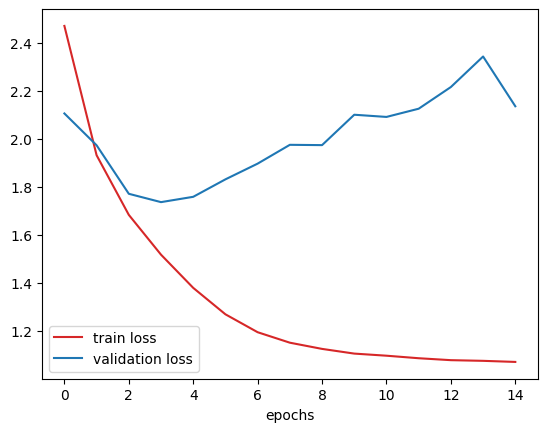

In [ ]:
train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)

layers=[3,64,128,256,512,512]
model = CNN4(layers,3,2)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
model.to(device)

train_loss, val_loss = train_epochs(model, criterion, optimizer, num_epochs)
model.eval();
print(f'Accuracy: {accuracy(model,test_loader)}%')
plot_loss(train_loss, val_loss)

## Batch Norm

Adding batch norm to every hidden layer should improve model.

Chose best architecture.

In [ ]:
class CNNBatchNorm(nn.Module):
    def __init__(self, layers):
      super(CNNBatchNorm, self).__init__()
      self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
      self.layers = nn.ModuleList()
      self.batchNorm = nn.ModuleList()

      out= (32,32) # calc output size for fully connected layer

      for input, output in zip(layers, layers[1:]):
        self.layers.append(nn.Conv2d(input, output, kernel_size=3, padding=2))
        out = conv_output_shape(out, kernel_size=3,pad =2)  # hidden layer
        out = conv_output_shape(out, 2,2)  # maxpool
        self.batchNorm.append(nn.BatchNorm2d(output))

      output_size = out[0]
      self.out1 = nn.Linear(layers[-1]*output_size*output_size, 512)
      self.out2 = nn.Linear(512, 120)
      self.out3 = nn.Linear(120, 10)

    def forward(self, x):
      for layer, bn in zip(self.layers, self.batchNorm):
        x = self.pool(F.relu(bn(layer(x))))
      x = torch.flatten(x, 1) # flatten all dimensions except batch
      x = F.relu(self.out1(x))
      x = F.relu(self.out2(x))
      x = self.out3(x)
      return x

epoch #1/15: train loss 2.2836, val loss 2.2199
epoch #2/15: train loss 1.8146, val loss 1.8983
epoch #3/15: train loss 1.6186, val loss 1.7031
epoch #4/15: train loss 1.4926, val loss 1.9116
epoch #5/15: train loss 1.3821, val loss 1.6671
epoch #6/15: train loss 1.2869, val loss 1.7380
epoch #7/15: train loss 1.2110, val loss 1.6733
epoch #8/15: train loss 1.1646, val loss 1.7976
epoch #9/15: train loss 1.1241, val loss 1.9312
epoch #10/15: train loss 1.0952, val loss 1.7925
epoch #11/15: train loss 1.0872, val loss 1.9052
epoch #12/15: train loss 1.0766, val loss 1.9056
epoch #13/15: train loss 1.0650, val loss 1.8675
epoch #14/15: train loss 1.0592, val loss 1.9540
epoch #15/15: train loss 1.0547, val loss 1.9918
Accuracy: 80.36%
bias: 1.0547, variance: 0.9371


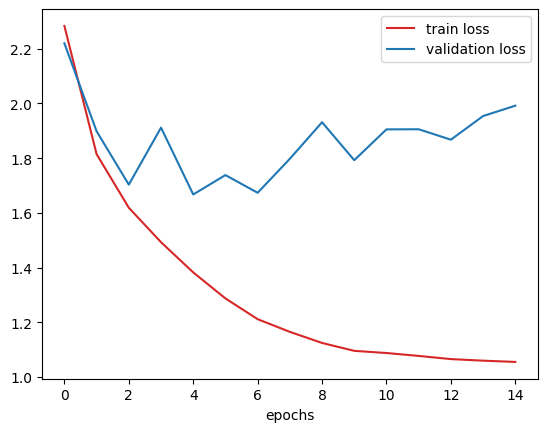

In [ ]:
batch_size = 64
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

layers=[3,64,128,256,512,512]
modelBN = CNNBatchNorm(layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelBN.parameters(), lr=0.0005)
num_epochs = 15

modelBN.to(device)

train_loss, val_loss = train_epochs(modelBN, criterion, optimizer, num_epochs)
modelBN.eval();
print(f'Accuracy: {accuracy(modelBN,test_loader)}%')
plot_loss(train_loss, val_loss)

Result: overfitting, train loss much lower than validation loss.

Now model needs regularization.

In [ ]:
layers=[3,64,128,256,512,512]
n = CNNBatchNorm(layers)
print(n)

CNNBatchNorm(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (batchNorm): ModuleList(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3-4): 2 x BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (out1): Linear(in_features=2048, out_features=512, bias=True)
  (out2): Linear(in_features=512

## Regularization

### Early Stopping

Adding early stopping will stop training before reaching num_epochs since we are overfitting.

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [ ]:
def train_epochs_early_stopping(model, criterion, optimizer, num_epochs,patience=5, delta=0.01):
  train_loss = []
  val_loss = []

  early_stopping = EarlyStopping(patience=patience, delta=delta)

  for epoch in range(num_epochs):
    train_loss_epoch = train_model(model, criterion, optimizer)
    train_loss.append(train_loss_epoch)

    test_loss_epoch = evaluate_model(model, criterion)
    val_loss.append(test_loss_epoch)

    early_stopping(test_loss_epoch, model)
    if early_stopping.early_stop:
        print("Early stopping")
        early_stopping.load_best_model(model)
        break

    print(f'epoch #{epoch+1}/{num_epochs}: train loss {train_loss_epoch:.4f}, val loss {test_loss_epoch:.4f}')

  return train_loss, val_loss

Add Early Stopping with patience 5 and delta 0.01.

epoch #1/15: train loss 2.2812, val loss 2.1401
epoch #2/15: train loss 1.7993, val loss 1.8302
epoch #3/15: train loss 1.6015, val loss 1.8070
epoch #4/15: train loss 1.4762, val loss 1.6452
epoch #5/15: train loss 1.3651, val loss 1.6921
epoch #6/15: train loss 1.2697, val loss 1.6651
epoch #7/15: train loss 1.2042, val loss 1.7437
epoch #8/15: train loss 1.1464, val loss 1.7609
Early stopping
Accuracy: 78.88%
bias: 1.1183, variance: 0.7732


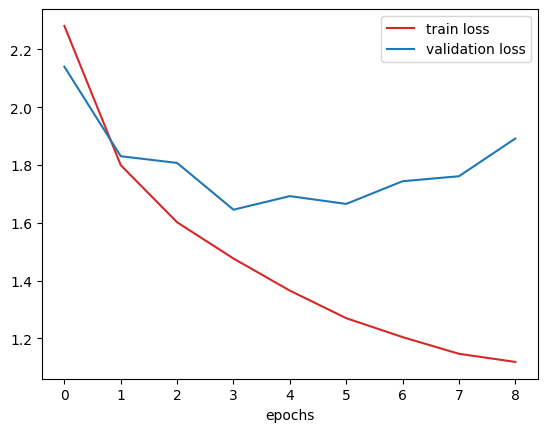

In [ ]:
layers=[3,64,128,256,512,512]
model = CNNBatchNorm(layers)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
num_epochs = 15

model.to(device)

train_loss, val_loss = train_epochs_early_stopping(model, criterion, optimizer, num_epochs)
model.eval();
print(f'Accuracy: {accuracy(model,test_loader)}%')
plot_loss(train_loss, val_loss)

Result: stopped early, accuracy lower and bias higher - patiance too small.

epoch #1/15: train loss 2.3691, val loss 2.3602
epoch #2/15: train loss 1.9040, val loss 1.9670
epoch #3/15: train loss 1.7173, val loss 1.7903
epoch #4/15: train loss 1.5897, val loss 1.6968
epoch #5/15: train loss 1.4881, val loss 1.7429
epoch #6/15: train loss 1.3957, val loss 1.6852
epoch #7/15: train loss 1.3173, val loss 1.7183
epoch #8/15: train loss 1.2548, val loss 1.7649
epoch #9/15: train loss 1.2015, val loss 1.7716
epoch #10/15: train loss 1.1608, val loss 1.8890
Early stopping
Accuracy: 77.31%
bias: 1.1430, variance: 0.8065


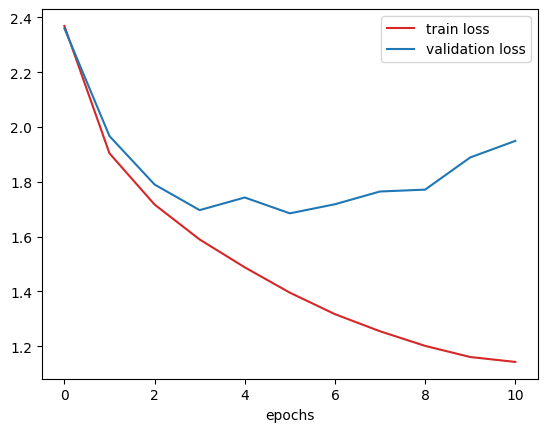

In [ ]:
layers=[3,32,64,128,256]
model = CNNBatchNorm(layers)
optimizer = optim.Adam(model.parameters(), lr=0.002)

model.to(device)

train_loss, val_loss = train_epochs_early_stopping(model, criterion, optimizer, num_epochs)
model.eval();
print(f'Accuracy: {accuracy(model,test_loader)}%')
plot_loss(train_loss, val_loss)

epoch #1/15: train loss 2.2644, val loss 2.2125
epoch #2/15: train loss 1.8089, val loss 1.7983
epoch #3/15: train loss 1.6105, val loss 1.6907
epoch #4/15: train loss 1.4872, val loss 1.6548
epoch #5/15: train loss 1.3714, val loss 1.6585
epoch #6/15: train loss 1.2835, val loss 1.7229
epoch #7/15: train loss 1.2084, val loss 1.7631
epoch #8/15: train loss 1.1585, val loss 1.7686
epoch #9/15: train loss 1.1232, val loss 1.7742
epoch #10/15: train loss 1.0951, val loss 1.8723
Early stopping
Accuracy: 80.0%
bias: 1.0819, variance: 0.8132


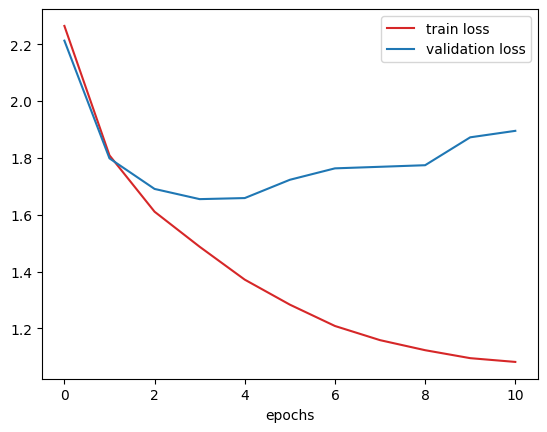

In [ ]:
layers=[3,64,128,256,512,512]
model = CNNBatchNorm(layers)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
model.to(device)

train_loss, val_loss = train_epochs_early_stopping(model, criterion, optimizer, num_epochs,patience=7, delta=0.01)
model.eval();
print(f'Accuracy: {accuracy(model,test_loader)}%')
plot_loss(train_loss, val_loss)

Result: still validation loss higher than train loss - overfitting.

Needs more regularization.

### Dropout

Adding dropout will force model to avoid memorizing the data, and do better on validation data - meaning variance should be lower, and so less overfitting.

#### Dropout to hidden layers after every maxpool layer

In [ ]:
#dropout after every maxpool layer
class CNNRegIn(nn.Module):
    '''dropout in every layer'''
    def __init__(self, layers,dropout):
      super(CNNRegIn, self).__init__()
      self.drop = nn.Dropout(p=dropout)
      self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
      self.layers = nn.ModuleList()
      self.batchNorm = nn.ModuleList()

      out= (32,32) # calc output size for fully connected layer

      for input, output in zip(layers, layers[1:]):
        self.layers.append(nn.Conv2d(input, output, kernel_size=3, padding=2))
        out = conv_output_shape(out, kernel_size=3,pad =2)  # hidden layer
        out = conv_output_shape(out, 2,2)  # maxpool
        self.batchNorm.append(nn.BatchNorm2d(output))

      output_size = out[0]
      self.out1 = nn.Linear(layers[-1]*output_size*output_size, 512)
      self.out2 = nn.Linear(512, 120)
      self.out3 = nn.Linear(120, 10)

    def forward(self, x):
      for layer, bn in zip(self.layers, self.batchNorm):
        x = self.drop(self.pool(F.relu(bn(layer(x)))))
      x = torch.flatten(x, 1) # flatten all dimensions except batch
      x = F.relu(self.out1(x))
      x  = F.relu(self.out2(x))
      x = self.out3(x)
      return x

epoch #1/15: train loss 2.4140, val loss 2.1230
epoch #2/15: train loss 1.9772, val loss 1.8736
epoch #3/15: train loss 1.7988, val loss 1.9532
epoch #4/15: train loss 1.6953, val loss 1.7362
epoch #5/15: train loss 1.6225, val loss 1.6568
epoch #6/15: train loss 1.5584, val loss 1.6949
epoch #7/15: train loss 1.5015, val loss 1.5938
epoch #8/15: train loss 1.4568, val loss 1.5629
epoch #9/15: train loss 1.4135, val loss 1.5492
epoch #10/15: train loss 1.3776, val loss 1.5763
epoch #11/15: train loss 1.3423, val loss 1.5919
epoch #12/15: train loss 1.3152, val loss 1.5430
epoch #13/15: train loss 1.2857, val loss 1.5623
epoch #14/15: train loss 1.2591, val loss 1.5460
epoch #15/15: train loss 1.2399, val loss 1.5339
Accuracy: 83.8%
bias: 1.2399, variance: 0.2940


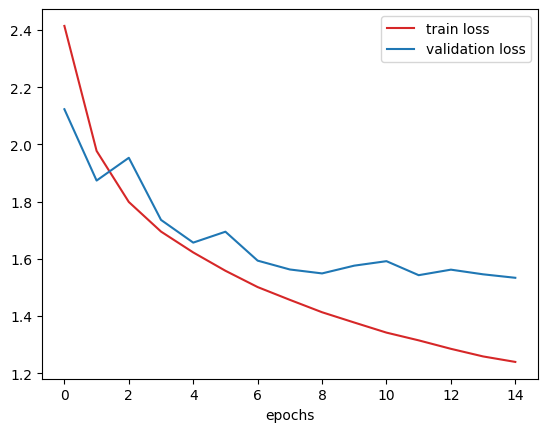

In [ ]:
layers=[3,64,128,256,512,512]
criterion = nn.CrossEntropyLoss()
num_epochs = 15

model = CNNRegIn(layers, dropout=0.2)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
model.to(device)

train_loss, val_loss = train_epochs_early_stopping(model, criterion, optimizer, num_epochs,patience=7, delta=0.01)
model.eval();
print(f'Accuracy: {accuracy(model,test_loader)}%')
plot_loss(train_loss, val_loss)

Result: much lower variance, model is not overfitting as much.

Since other neurons every layer are active, model learns to pay attention to the more important data.

#### Dropout to last linear outer layers

In [ ]:
class CNNRegEnd(nn.Module):
    '''dropout in outer layers, 3 outer layers'''
    def __init__(self, layers,dropout):
      super(CNNRegEnd, self).__init__()
      self.drop = nn.Dropout(p=dropout)
      self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
      self.layers = nn.ModuleList()
      self.batchNorm = nn.ModuleList()

      out= (32,32) # calc output size for fully connected layer

      for input, output in zip(layers, layers[1:]):
        self.layers.append(nn.Conv2d(input, output, kernel_size=3, padding=2))
        out = conv_output_shape(out, kernel_size=3,pad =2)  # hidden layer
        out = conv_output_shape(out, 2,2)  # maxpool
        self.batchNorm.append(nn.BatchNorm2d(output))

      output_size = out[0]
      self.out1 = nn.Linear(layers[-1]*output_size*output_size, 512)
      self.out2 = nn.Linear(512, 120)
      self.out3 = nn.Linear(120, 10)

    def forward(self, x):
      for layer, bn in zip(self.layers, self.batchNorm):
        x = self.pool(F.relu(bn(layer(x))))
      x = torch.flatten(x, 1) # flatten all dimensions except batch
      x = F.relu(self.out1(x))
      x = self.drop(x)
      x = F.relu(self.out2(x))
      x = self.drop(x)
      x = self.out3(x)
      return x

epoch #1/15: train loss 2.3451, val loss 1.9805
epoch #2/15: train loss 1.8679, val loss 1.8708
epoch #3/15: train loss 1.6662, val loss 1.8278
epoch #4/15: train loss 1.5344, val loss 1.9810
epoch #5/15: train loss 1.4288, val loss 1.7696
epoch #6/15: train loss 1.3365, val loss 1.6633
epoch #7/15: train loss 1.2551, val loss 1.7581
epoch #8/15: train loss 1.2018, val loss 1.6744
epoch #9/15: train loss 1.1539, val loss 1.7756
epoch #10/15: train loss 1.1249, val loss 1.8593
epoch #11/15: train loss 1.1002, val loss 1.8593
epoch #12/15: train loss 1.0892, val loss 2.0149
Early stopping
Accuracy: 81.79%
bias: 1.0792, variance: 0.7909


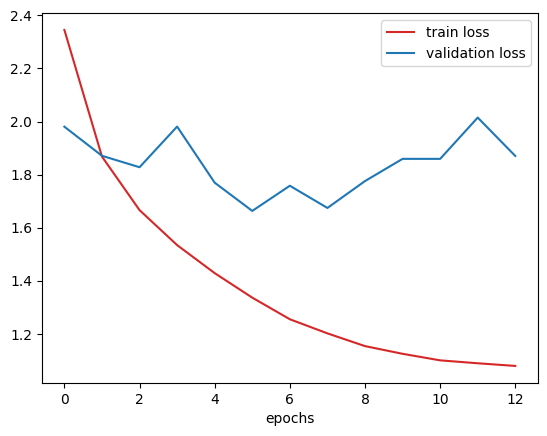

In [ ]:
model = CNNRegEnd(layers, dropout=0.2)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
model.to(device)

train_loss, val_loss = train_epochs_early_stopping(model, criterion, optimizer, num_epochs,patience=7, delta=0.01)
model.eval();
print(f'Accuracy: {accuracy(model,test_loader)}%')
plot_loss(train_loss, val_loss)

Result: while bias is slightly lower, variance is much higher.

The model memorizing training data and is less successful on new data: overfitting.

Dropout only on the last layers is not enough regularization.

### Weight Decay

To combat overfitting, to the better architecture - CNNRegIn - we add weight decay.

epoch #1/15: train loss 2.3873, val loss 2.1179
epoch #2/15: train loss 1.9905, val loss 1.8413
epoch #3/15: train loss 1.8093, val loss 1.9206
epoch #4/15: train loss 1.7100, val loss 1.8079
epoch #5/15: train loss 1.6336, val loss 1.7297
epoch #6/15: train loss 1.5662, val loss 1.6091
epoch #7/15: train loss 1.5206, val loss 1.5599
epoch #8/15: train loss 1.4771, val loss 1.5993
epoch #9/15: train loss 1.4408, val loss 1.6209
epoch #10/15: train loss 1.3949, val loss 1.5273
epoch #11/15: train loss 1.3706, val loss 1.5816
epoch #12/15: train loss 1.3448, val loss 1.5418
epoch #13/15: train loss 1.3224, val loss 1.5184
epoch #14/15: train loss 1.2969, val loss 1.6700
epoch #15/15: train loss 1.2776, val loss 1.5421
Accuracy: 83.62%
bias: 1.2776, variance: 0.2645


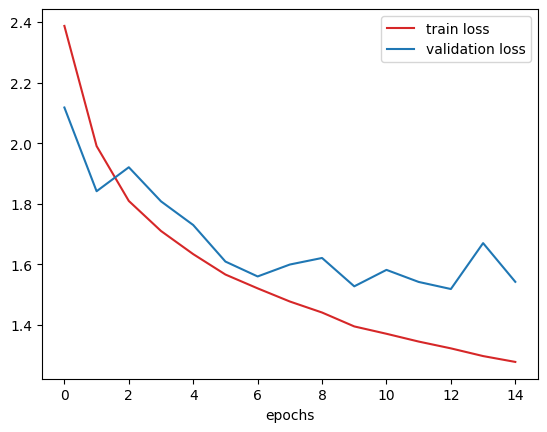

In [ ]:
layers=[3,64,128,256,512,512]
criterion = nn.CrossEntropyLoss()
num_epochs = 15

model = CNNRegIn(layers, dropout=0.2)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001)
model.to(device)

train_loss, val_loss = train_epochs_early_stopping(model, criterion, optimizer, num_epochs,patience=7, delta=0.01)
model.eval();
print(f'Accuracy: {accuracy(model,test_loader)}%')
plot_loss(train_loss, val_loss)

Result: Weight decay is not helpful. Lowered accuracy - higher bias.

Attempt higher weight decay.

epoch #1/15: train loss 2.4188, val loss 2.1731
epoch #2/15: train loss 2.0057, val loss 2.1362
epoch #3/15: train loss 1.8528, val loss 1.8109
epoch #4/15: train loss 1.7564, val loss 1.7218
epoch #5/15: train loss 1.6936, val loss 1.9041
epoch #6/15: train loss 1.6442, val loss 1.7450
epoch #7/15: train loss 1.6057, val loss 1.6730
epoch #8/15: train loss 1.5669, val loss 1.5964
epoch #9/15: train loss 1.5429, val loss 1.6081
epoch #10/15: train loss 1.5161, val loss 1.5655
epoch #11/15: train loss 1.4882, val loss 1.5916
epoch #12/15: train loss 1.4739, val loss 1.6044
epoch #13/15: train loss 1.4550, val loss 1.5524
epoch #14/15: train loss 1.4423, val loss 1.5451
epoch #15/15: train loss 1.4254, val loss 1.5051
Accuracy: 82.76%
bias: 1.4254, variance: 0.0796


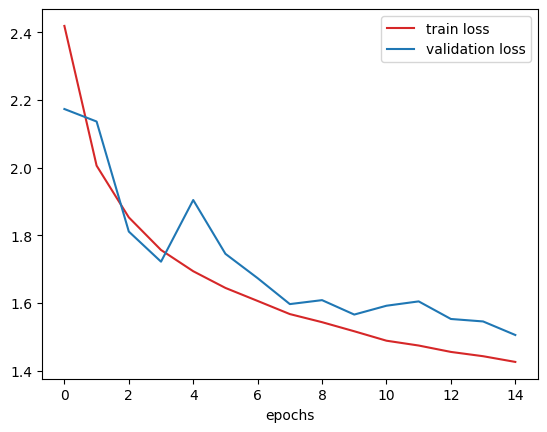

In [ ]:
layers=[3,64,128,256,512,512]
criterion = nn.CrossEntropyLoss()
num_epochs = 15

model = CNNRegIn(layers, dropout=0.2)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.001)
model.to(device)

train_loss, val_loss = train_epochs_early_stopping(model, criterion, optimizer, num_epochs,patience=7, delta=0.01)
model.eval();
print(f'Accuracy: {accuracy(model,test_loader)}%')
plot_loss(train_loss, val_loss)

Result: higher weight decay higher bias. Not good.

### Other Regularization experiments

#### drop 0.2 same architecture, higher learning rate

To see if changes in architecture may require different learning rate than before.

epoch #1/15: train loss 2.3098, val loss 2.3660
epoch #2/15: train loss 1.8427, val loss 1.9571
epoch #3/15: train loss 1.6596, val loss 1.8326
epoch #4/15: train loss 1.5304, val loss 1.7539
epoch #5/15: train loss 1.4322, val loss 1.6699
epoch #6/15: train loss 1.3585, val loss 1.7063
epoch #7/15: train loss 1.2985, val loss 1.7013
epoch #8/15: train loss 1.2425, val loss 1.7284
epoch #9/15: train loss 1.2068, val loss 1.8478
Early stopping
Accuracy: 78.52%
bias: 1.1831, variance: 0.5759


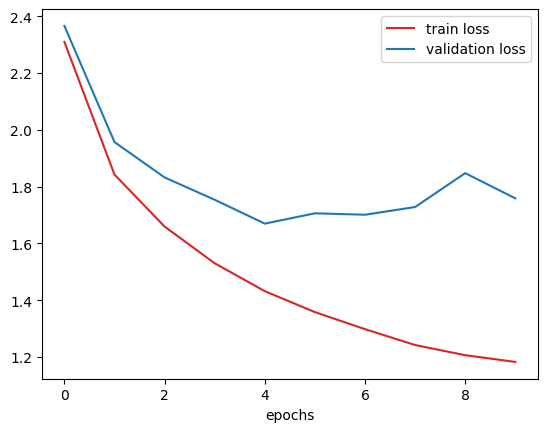

In [ ]:
layers=[3,64,128,256,512,512]
modelDrop2 = CNNRegIn(layers, dropout=0.2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelDrop2.parameters(), lr=2e-3)
num_epochs = 15

modelDrop2.to(device)

train_loss, val_loss = train_epochs_early_stopping(modelDrop2, criterion, optimizer, num_epochs)
modelDrop2.eval();
print(f'Accuracy: {accuracy(modelDrop2,test_loader)}%')
plot_loss(train_loss, val_loss)

Result: more overfit, accuracy lower. Didn't help as expected.

#### same as above but with weight decay

epoch #1/15: train loss 2.3594, val loss 2.4360
epoch #2/15: train loss 1.9966, val loss 2.2089
epoch #3/15: train loss 1.8562, val loss 1.9797
epoch #4/15: train loss 1.7868, val loss 1.9061
epoch #5/15: train loss 1.7459, val loss 1.9071
epoch #6/15: train loss 1.7075, val loss 1.7920
epoch #7/15: train loss 1.6877, val loss 1.8498
epoch #8/15: train loss 1.6705, val loss 1.9768
epoch #9/15: train loss 1.6535, val loss 1.8207
epoch #10/15: train loss 1.6415, val loss 1.8592
Early stopping
Accuracy: 72.76%
bias: 1.6296, variance: 0.1723


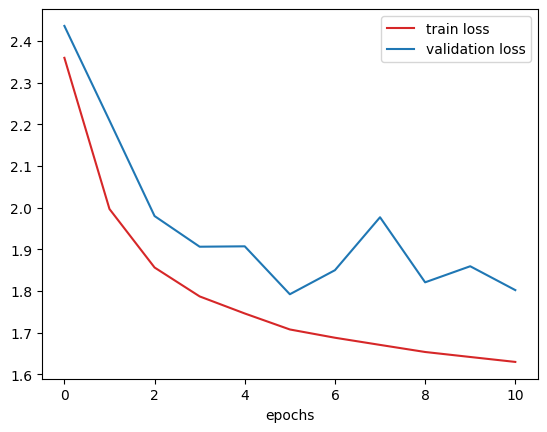

In [ ]:
layers=[3,64,128,256,512,512]
modelDrop3 = CNNRegIn(layers, dropout=0.2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelDrop3.parameters(), lr=2e-3, weight_decay=0.001)
num_epochs = 15

modelDrop3.to(device)

train_loss, val_loss = train_epochs_early_stopping(modelDrop3, criterion, optimizer, num_epochs)
modelDrop3.eval();
print(f'Accuracy: {accuracy(modelDrop3,test_loader)}%')
plot_loss(train_loss, val_loss)

Result: variance is lower, but bias is high and it seems the model has even more difficulty learning.

This learning rate (0.002) is too high for the complexity of the model.

#### higher dropout

To see id the model can overcome high learning rate with dropout.

epoch #1/15: train loss 2.4207, val loss 2.8949
epoch #2/15: train loss 2.0999, val loss 2.5384
epoch #3/15: train loss 1.9730, val loss 2.5007
epoch #4/15: train loss 1.9061, val loss 2.2211
epoch #5/15: train loss 1.8560, val loss 2.2071
epoch #6/15: train loss 1.8237, val loss 2.0353
epoch #7/15: train loss 1.8022, val loss 2.0542
epoch #8/15: train loss 1.7827, val loss 2.2542
epoch #9/15: train loss 1.7714, val loss 2.1840
epoch #10/15: train loss 1.7546, val loss 2.0224
epoch #11/15: train loss 1.7488, val loss 2.1506
epoch #12/15: train loss 1.7452, val loss 2.2629
epoch #13/15: train loss 1.7340, val loss 2.0197
epoch #14/15: train loss 1.7260, val loss 2.1757
epoch #15/15: train loss 1.7255, val loss 1.8935
Accuracy: 72.51%
bias: 1.7255, variance: 0.1680


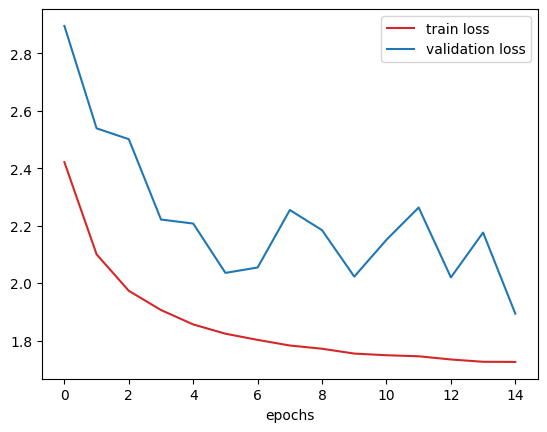

In [ ]:
layers=[3,32,64,128,256,512,512]
modelReg = CNNRegIn(layers, dropout=0.3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelReg.parameters(), lr=2e-3,weight_decay=0.001)
num_epochs = 15

modelReg.to(device)

train_loss, val_loss = train_epochs_early_stopping(modelReg, criterion, optimizer, num_epochs)
modelReg.eval();
print(f'Accuracy: {accuracy(modelReg,test_loader)}%')
plot_loss(train_loss, val_loss)

Result: higher variance and bias, meaning model has more difficulty learning, not less.

## ResNet50

different data normalization from resnet tutorial

In [ ]:
transform_2 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset_2 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_2)
testset_2 = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_2)

batch_size = 64
train_loader = DataLoader(trainset_2, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset_2, batch_size=batch_size, shuffle=False)

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# Import ResNet50 model pretrained on ImageNet
model = models.resnet50(pretrained=True)

#Modify conv1 to suit CIFAR-10
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

# Modify the final fully connected layer according to the number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

100%|██████████| 170M/170M [00:02<00:00, 61.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s]


epoch #1/15: train loss 1.9042, val loss 1.6945
epoch #2/15: train loss 1.4975, val loss 1.5667
epoch #3/15: train loss 1.3480, val loss 1.4757
epoch #4/15: train loss 1.2502, val loss 1.4985
epoch #5/15: train loss 1.1913, val loss 1.5041
epoch #6/15: train loss 1.1443, val loss 1.5443
epoch #7/15: train loss 1.1281, val loss 1.5484
epoch #8/15: train loss 1.0999, val loss 1.5801
epoch #9/15: train loss 1.0868, val loss 1.5821
Early stopping
Accuracy: 85.91%
bias: 1.0824, variance: 0.4748


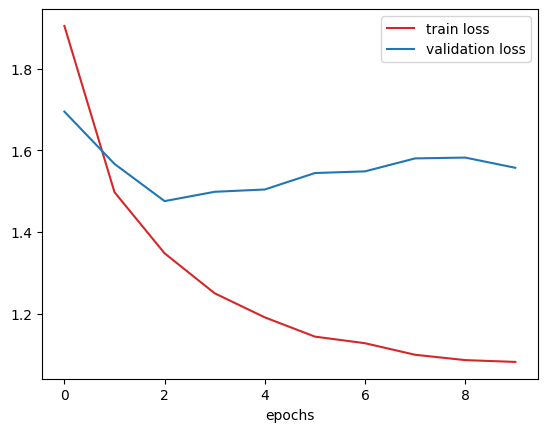

In [ ]:
num_epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
model.to(device)

train_loss, val_loss = train_epochs_early_stopping(model, criterion, optimizer, num_epochs,patience=7, delta=0.01)
model.eval();
print(f'Accuracy: {accuracy(model,test_loader)}%')
plot_loss(train_loss, val_loss)

ResNet50 with SGD optim

epoch #1/15: train loss 1.9577, val loss 1.5118
epoch #2/15: train loss 1.4372, val loss 1.4658
epoch #3/15: train loss 1.2823, val loss 1.3895
epoch #4/15: train loss 1.2001, val loss 1.4601
epoch #5/15: train loss 1.1589, val loss 1.3886
epoch #6/15: train loss 1.1245, val loss 1.5437
epoch #7/15: train loss 1.1209, val loss 1.5222
epoch #8/15: train loss 1.1005, val loss 1.4763
epoch #9/15: train loss 1.0984, val loss 1.5294
epoch #10/15: train loss 1.0913, val loss 1.5060
epoch #11/15: train loss 1.0875, val loss 1.4753
epoch #12/15: train loss 1.0803, val loss 1.4919
Early stopping
Accuracy: 86.22%
bias: 1.0816, variance: 0.4225


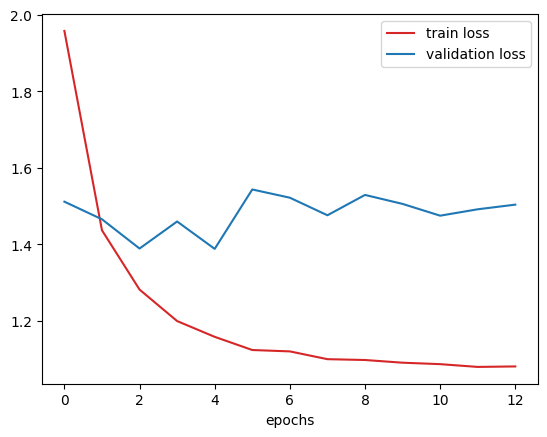

In [ ]:
# Import ResNet50 model pretrained on ImageNet
model2 = models.resnet50(pretrained=True)

#Modify conv1 to suit CIFAR-10
model2.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

# Modify the final fully connected layer according to the number of classes
num_features = model2.fc.in_features
model2.fc = nn.Linear(num_features, 10)

num_epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=0.01,momentum=0.9, weight_decay=0.0005)
model2.to(device)

train_loss, val_loss = train_epochs_early_stopping(model2, criterion, optimizer, num_epochs,patience=10, delta=0.01)
model2.eval();
print(f'Accuracy: {accuracy(model2,test_loader)}%')
plot_loss(train_loss, val_loss)

ResNet50 with SGD optim and higher learning rate

epoch #1/30: train loss 1.9344, val loss 1.6061
epoch #2/30: train loss 1.4251, val loss 1.4388
epoch #3/30: train loss 1.2737, val loss 1.4087
epoch #4/30: train loss 1.1915, val loss 1.4493
epoch #5/30: train loss 1.1613, val loss 1.4556
epoch #6/30: train loss 1.1369, val loss 1.5203
epoch #7/30: train loss 1.1083, val loss 1.4763
epoch #8/30: train loss 1.0991, val loss 1.4814
epoch #9/30: train loss 1.0973, val loss 1.4942
epoch #10/30: train loss 1.0909, val loss 1.5532
epoch #11/30: train loss 1.0801, val loss 1.5055
epoch #12/30: train loss 1.0873, val loss 1.5035
Early stopping
Accuracy: 85.86%
bias: 1.0832, variance: 0.4265


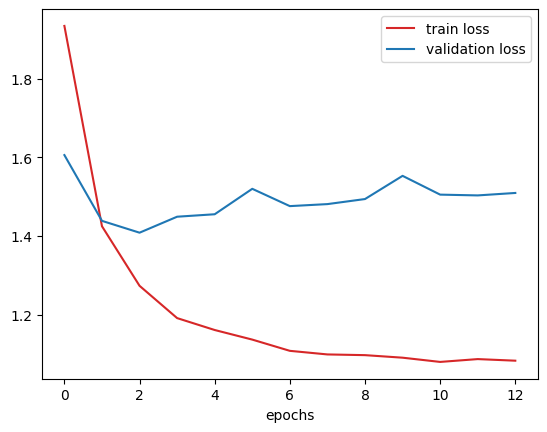

In [ ]:
# Import ResNet50 model pretrained on ImageNet
model3 = models.resnet50(pretrained=True)

#Modify conv1 to suit CIFAR-10
model3.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

# Modify the final fully connected layer according to the number of classes
num_features = model3.fc.in_features
model3.fc = nn.Linear(num_features, 10)

num_epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=0.01,momentum=0.9, weight_decay=0.0005)
model3.to(device)

train_loss, val_loss = train_epochs_early_stopping(model3, criterion, optimizer, num_epochs,patience=10, delta=0.01)
model3.eval();
print(f'Accuracy: {accuracy(model3,test_loader)}%')
plot_loss(train_loss, val_loss)

my chosen model with this data normalization:

epoch #1/15: train loss 2.3848, val loss 2.1144
epoch #2/15: train loss 1.9709, val loss 2.0305
epoch #3/15: train loss 1.7994, val loss 1.8124
epoch #4/15: train loss 1.6954, val loss 1.6994
epoch #5/15: train loss 1.6138, val loss 1.6440
epoch #6/15: train loss 1.5567, val loss 1.5946
epoch #7/15: train loss 1.4980, val loss 1.5895
epoch #8/15: train loss 1.4537, val loss 1.6544
epoch #9/15: train loss 1.4099, val loss 1.6459
epoch #10/15: train loss 1.3739, val loss 1.5844
epoch #11/15: train loss 1.3441, val loss 1.5092
epoch #12/15: train loss 1.3096, val loss 1.5440
epoch #13/15: train loss 1.2771, val loss 1.5532
epoch #14/15: train loss 1.2594, val loss 1.5406
epoch #15/15: train loss 1.2362, val loss 1.6208
Accuracy: 82.25%
bias: 1.2362, variance: 0.3846


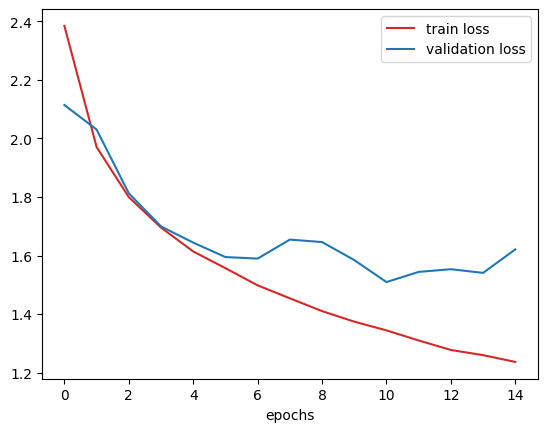

In [ ]:
layers=[3,64,128,256,512,512]
criterion = nn.CrossEntropyLoss()
num_epochs = 15

my_model = CNNRegIn(layers, dropout=0.2)
optimizer = optim.Adam(my_model.parameters(), lr=0.0005)
my_model.to(device)

train_loss, val_loss = train_epochs_early_stopping(my_model, criterion, optimizer, num_epochs,patience=7, delta=0.01)
my_model.eval();
print(f'Accuracy: {accuracy(my_model,test_loader)}%')
plot_loss(train_loss, val_loss)

## Final model architecture

In [ ]:
# Split trainset into training and validation sets
train_size = int(0.8 * len(trainset))  # 80% for training
val_size = len(trainset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
def train_model(model, criterion, optimizer,train_loader):
    model.train()
    train_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    return train_loss/i+1


def evaluate_model(model, criterion,val_loader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
      for i, data in enumerate(val_loader):
            test_data, test_target = data[0].to(device), data[1].to(device)
            outputs = model(test_data)
            loss = criterion(outputs, test_target)
            val_loss += loss.item()

    return val_loss/i+1

def train_epochs(model, criterion, optimizer, num_epochs,train_loader,val_loader,patience=10, delta=0.01):
  train_loss = []
  val_loss = []

  early_stopping = EarlyStopping(patience=patience, delta=delta)

  for epoch in range(num_epochs):
    train_loss_epoch = train_model(model, criterion, optimizer,train_loader)
    train_loss.append(train_loss_epoch)

    test_loss_epoch = evaluate_model(model, criterion,val_loader)
    val_loss.append(test_loss_epoch)

    early_stopping(test_loss_epoch, model)
    if early_stopping.early_stop:
        print("Early stopping")
        early_stopping.load_best_model(model)
        break

    print(f'epoch #{epoch+1}/{num_epochs}: train loss {train_loss_epoch:.4f}, val loss {test_loss_epoch:.4f}')

  return train_loss, val_loss

Decided on this architecture:

In [ ]:
#dropout after every maxpool layer
class CNNRegIn(nn.Module):
    '''dropout in every layer'''
    def __init__(self, layers,dropout):
      super(CNNRegIn, self).__init__()
      self.drop = nn.Dropout(p=dropout)
      self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
      self.layers = nn.ModuleList()
      self.batchNorm = nn.ModuleList()

      out= (32,32) # calc output size for fully connected layer

      for input, output in zip(layers, layers[1:]):
        self.layers.append(nn.Conv2d(input, output, kernel_size=3, padding=2))
        out = conv_output_shape(out, kernel_size=3,pad =2)  # hidden layer
        out = conv_output_shape(out, 2,2)  # maxpool
        self.batchNorm.append(nn.BatchNorm2d(output))

      output_size = out[0]
      self.out1 = nn.Linear(layers[-1]*output_size*output_size, 512)
      self.out2 = nn.Linear(512, 120)
      self.out3 = nn.Linear(120, 10)

    def forward(self, x):
      for layer, bn in zip(self.layers, self.batchNorm):
        x = self.drop(self.pool(F.relu(bn(layer(x)))))
      x = torch.flatten(x, 1) # flatten all dimensions except batch
      x = F.relu(self.out1(x))
      x  = F.relu(self.out2(x))
      x = self.out3(x)
      return x

In [ ]:
layers=[3,64,128,256,512,512]
final_model = CNNRegIn(layers, dropout=0.2)
print(final_model)

CNNRegIn(
  (drop): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (batchNorm): ModuleList(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3-4): 2 x BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (out1): Linear(in_features=2048, out_features=512, bias=Tr

epoch #1/30: train loss 2.4065, val loss 2.2145
epoch #2/30: train loss 2.0277, val loss 1.9243
epoch #3/30: train loss 1.8548, val loss 1.8806
epoch #4/30: train loss 1.7416, val loss 1.7087
epoch #5/30: train loss 1.6569, val loss 1.6291
epoch #6/30: train loss 1.5921, val loss 1.5948
epoch #7/30: train loss 1.5320, val loss 1.6275
epoch #8/30: train loss 1.4787, val loss 1.5848
epoch #9/30: train loss 1.4356, val loss 1.5959
epoch #10/30: train loss 1.3991, val loss 1.5750
epoch #11/30: train loss 1.3611, val loss 1.5897
epoch #12/30: train loss 1.3248, val loss 1.5594
epoch #13/30: train loss 1.2948, val loss 1.5604
epoch #14/30: train loss 1.2702, val loss 1.5744
epoch #15/30: train loss 1.2505, val loss 1.5810
epoch #16/30: train loss 1.2268, val loss 1.6390
epoch #17/30: train loss 1.2096, val loss 1.5529
epoch #18/30: train loss 1.1947, val loss 1.5864
epoch #19/30: train loss 1.1754, val loss 1.6071
epoch #20/30: train loss 1.1628, val loss 1.6437
epoch #21/30: train loss 1.15

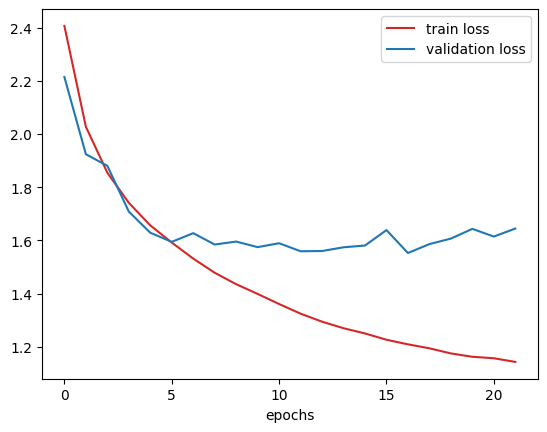

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=0.0005)
num_epochs = 30

final_model.to(device)

train_loss, val_loss = train_epochs(final_model, criterion, optimizer, num_epochs,train_loader,val_loader)
final_model.eval()
print(f'Accuracy: {accuracy(final_model,test_loader)}%')
plot_loss(train_loss, val_loss)